# Machine Learning Approaches to L/S-TLF

## LSTM (Long Short-Term Memory)

### Loading and Cleaning Data

This will also include exogenous variables: temperature, windspeed, and (proxied) sun coverage. A lot of this initial code will be exactly the same as in the TR notebook.

N.B. The variable naming convention:

- `.lt..` denotes long-term data (monthly over years)
- `.st..` denotes short-term data (daily over one year)
- `...oc` denotes one-column data (without exogenous variables)
- `...mc` denotes multi-column data (with exogenous variables)
- `g....` in front of a variable denotes that it will be the GRU variant (LSTM by default)

- `sc..` means scaled
- `..tr`, `..vl`, `..ts` mean training, validation, and test sets respectively

- `X..` is the input (I know this would typically indicate a constant variable in Python, but it is more consistent with mathematical notation)
- `y..` is the label

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from typing import Type, Optional
import pandera as pa
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta

import meteostat as met

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [157]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [158]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [159]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [160]:
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [161]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [162]:
# timeseries data breakout
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [163]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,2009-01-01,2009-01-01,NaN


Weather Data (as in TR)

In [164]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [165]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [166]:
sun_factor_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_factor_09[(sun_factor_09.index >= pd.to_datetime("2011-01-01"))]

combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat, sun_data], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

In [167]:
mean_wdat.head()

,sun_eff,tavg,wspd
2011-01-01,0.018301,5.300,14.400
2011-02-01,0.026512,7.500,18.000
2011-03-01,0.068665,8.925,15.775
2011-04-01,0.117791,13.100,13.550
2011-05-01,0.125091,13.580,14.300


In [168]:
ltoc = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

In [169]:
scaler_ltoc = MinMaxScaler(feature_range=(0, 1))

In [170]:
agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])

Some of the following code has been taken from the very helpful tutorial by Greg Hogg (https://www.youtube.com/watch?v=c0k-YLQGKjY, https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=EbrFD1vMR_qS). These resources and other miscellaneous StackExchange threads on parameter selection and tuning have been use to construct the following models.

In [171]:
def col_Xy(col: Series, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(col)-seasonal_order):
    window = [a for a in col[i:i+seasonal_order]]
    X.append(window)
    label = col[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

The function takes the previous `seasonal_order` number of values and then labels them with the `seasonal_order + 1`-th value

In [172]:
SEASON_LTLF = 11

11 is chosen because we want to predict the 12th value based on the previous 11. The idea is that the window size (ML `seasonal_order`) is the traditional seasonal order - 1.

In [173]:
Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)

In [174]:
Xtr_ltoc[0]

array([[0.92964219],
       [0.88378702],
       [0.6664977 ],
       [0.44309417],
       [0.3433566 ],
       [0.34481605],
       [0.31615413],
       [0.2784782 ],
       [0.3665271 ],
       [0.48840659],
       [0.63882912]])

In [175]:
ytr_ltoc[0]

array([0.82318279])

In [176]:
Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)

### Running the LTLF

First I build the model, as shown in much of the documentation, StackOverflow recommendations, and various tutorials online

In [177]:

ltoc_model = Sequential()
ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
ltoc_model.add(LSTM(128, return_sequences=True))
ltoc_model.add(LSTM(128))
ltoc_model.add(Dense(8, 'relu'))
ltoc_model.add(Dense(1, 'linear'))

ltoc_model.summary()

Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_202 (LSTM)                 │ (None, 11, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_203 (LSTM)                 │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

I set a checkpoint for the epochs so that we can load the optimal model later and I compile the model.

In [178]:
cp = ModelCheckpoint('models/ltoc_model.keras', save_best_only=True)
ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Finally, I fit the model.

In [179]:
ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.1956 - root_mean_squared_error: 0.4422 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3785
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0904 - root_mean_squared_error: 0.3001 - val_loss: 0.1382 - val_root_mean_squared_error: 0.3717
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0868 - root_mean_squared_error: 0.2943 - val_loss: 0.1205 - val_root_mean_squared_error: 0.3471
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0640 - root_mean_squared_error: 0.2527 - val_loss: 0.1183 - val_root_mean_squared_error: 0.3439
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0641 - root_mean_squared_error: 0.2527 - val_loss: 0.1205 - val_root_mean_squared_error: 0.3471
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0712 - root_mean_squared_error: 0.2667 - val_loss: 0.1132 - val_root_mean_squared_error: 0.3364
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0643 - roo

Load the best model.

In [180]:
ltoc_model = load_model('models/ltoc_model.keras')

I unscale the data.

In [181]:
pred_ltoc = ltoc_model.predict(Xts_ltoc)
pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)

yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


I plot the predicted values on the actuals to see how well the model did, and I output the MAPE.

FIX BORDERS AND TICKS!!!!

In [182]:
def plot_fcast_ml(agg_data: DataFrame, val_start: str, test_start: str, test_end: str, pred_arr: np.ndarray, exog: bool) -> None:
    
    if exog:
        actualized_df = agg_data[(agg_data.index >= pd.to_datetime(val_start)) & (agg_data.index < pd.to_datetime(test_end))]["ND"]
    else:
        actualized_df = agg_data[(agg_data.index >= pd.to_datetime(val_start)) & (agg_data.index < pd.to_datetime(test_end))]
    
    dates_ts = actualized_df[actualized_df.index >= pd.to_datetime(test_start)].index.to_list()

    pred_arr = pd.Series(pred_arr.flatten())
    
    pred_arr.index = dates_ts

    fig, ax = plt.subplots(figsize=(6, 5))

    ax.grid(visible=True, linewidth=0.5)
    
    [x.set_linewidth(0.15) for x in ax.spines.values()]

    ax.tick_params(left=False, bottom=False)

    ax.plot(actualized_df, label='Actual', color="C0")
    ax.plot(pred_arr, label='Predicted', color="orange")

    plt.ylim(0, 50000)

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("National Demand (MW)")
    plt.xticks(rotation=45)

    plt.show()

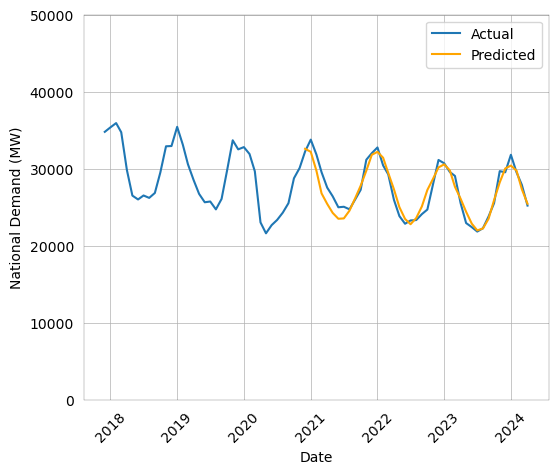

MAPE: 3.291%


In [183]:
plot_fcast_ml(agg_ltoc, "2017-12-01", "2020-12-01", "2024-05-01", pred_ltoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_ltoc, pred_ltoc)*100:.3f}%")

This process will be repeated 7 more times with LSTM/GRU and `..oc`, `..mc` inputs.

### LTLF with Exogenous Variables

In [184]:
def df_Xy(df: DataFrame, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(df)-seasonal_order):
    row = [a for a in df[i:i+seasonal_order]]
    X.append(row)
    label = df[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

This is a modified col_Xy built for `..mc` datasets.

In [185]:
ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")

In [186]:
scaler_ltmc = MinMaxScaler(feature_range=(0, 1))

sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)

In [187]:
ltmc_model = Sequential()
ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
ltmc_model.add(LSTM(512, return_sequences=True))
ltmc_model.add(LSTM(256))
ltmc_model.add(Dense(32, 'relu'))
ltmc_model.add(Dense(4, 'linear'))

ltmc_model.summary()

Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_204 (LSTM)                 │ (None, 11, 512)        │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_205 (LSTM)                 │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,854,628 (7.07 MB)

 Trainable params: 1,854,628 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
cp = ModelCheckpoint('models/ltmc_model.keras', save_best_only=True)
ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - loss: 0.2013 - root_mean_squared_error: 0.4483 - val_loss: 0.1259 - val_root_mean_squared_error: 0.3548
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0900 - root_mean_squared_error: 0.2999 - val_loss: 0.0938 - val_root_mean_squared_error: 0.3062
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0682 - root_mean_squared_error: 0.2609 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2897
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0581 - root_mean_squared_error: 0.2409 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2877
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0567 - root_mean_squared_error: 0.2380 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2746
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0528 -

In [189]:
ltmc_model = load_model('models/ltmc_model.keras')
pred_ltmc = ltmc_model.predict(Xts_ltmc)
pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]

yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


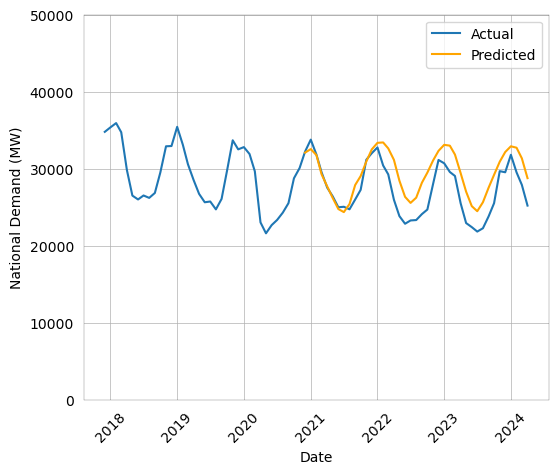

MAPE: 8.918%


In [190]:
plot_fcast_ml(ltmc, "2017-12-01", "2020-12-01", "2024-05-01", pred_ltmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_ltmc, pred_ltmc)*100:.3f}%")

### STLF

In [191]:
SEASON_STLF = 6

In [192]:
stoc = df[["YMD", "ND"]].groupby("YMD").agg("mean").asfreq("D")

In [193]:
w_start = datetime.datetime(2022, 1, 1)
w_end = datetime.datetime(2022, 12, 31)

In [194]:
ldn_dwdat = met.Daily(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_dwdat = met.Daily(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_dwdat = met.Daily(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [195]:
sun_dfactor = df[["YMD", "sun_eff"]].groupby("YMD").agg("mean").asfreq("D")
sun_ddata = sun_dfactor[(sun_dfactor.index >= pd.to_datetime("2022-01-01")) & (sun_dfactor.index <= pd.to_datetime("2022-12-31"))]

combined_dwdat = pd.concat([ldn_dwdat, edi_dwdat, cdf_dwdat, sun_ddata], axis=1)

mean_dwdat = combined_dwdat.T.groupby(combined_dwdat.columns).agg("mean").T

In [196]:
agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")

In [197]:
scaler_stoc = MinMaxScaler(feature_range=(0, 1))

sctr_stoc = scaler_stoc.fit_transform(agg_stoc[agg_stoc.index < pd.to_datetime("2022-05-01")])
scvl_stoc = scaler_stoc.fit_transform(agg_stoc[(agg_stoc.index >= pd.to_datetime("2022-05-01")) & (agg_stoc.index < pd.to_datetime("2022-07-15"))])
scts_stoc = scaler_stoc.fit_transform(agg_stoc[agg_stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)

In [198]:
stoc_model = Sequential()
stoc_model.add(InputLayer((SEASON_STLF, 1)))
stoc_model.add(LSTM(256, return_sequences=True))
stoc_model.add(LSTM(256))
stoc_model.add(Dense(8, 'relu'))
stoc_model.add(Dense(1, 'linear'))

stoc_model.summary()

Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_206 (LSTM)                 │ (None, 6, 256)         │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_207 (LSTM)                 │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 791,569 (3.02 MB)

 Trainable params: 791,569 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

In [199]:
cp = ModelCheckpoint('models/stoc_model.keras', save_best_only=True)
stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.3059 - root_mean_squared_error: 0.5523 - val_loss: 0.0720 - val_root_mean_squared_error: 0.2683
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0639 - root_mean_squared_error: 0.2522 - val_loss: 0.1001 - val_root_mean_squared_error: 0.3164
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0435 - root_mean_squared_error: 0.2075 - val_loss: 0.0604 - val_root_mean_squared_error: 0.2457
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0461 - root_mean_squared_error: 0.2146 - val_loss: 0.0561 - val_root_mean_squared_error: 0.2369
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0299 - root_mean_squared_error: 0.1727 - val_loss: 0.0644 - val_root_mean_squared_error: 0.2538
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0322 - root_mean_squared_error: 0.1794 - val_loss: 0.0572 - val_root_mean_squared_error: 0.2392
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0279 - roo

In [200]:
stoc_model = load_model('models/stoc_model.keras')

pred_stoc = stoc_model.predict(Xts_stoc)
pred_stoc = scaler_stoc.inverse_transform(pred_stoc)

yts_stoc = scaler_stoc.inverse_transform(yts_stoc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


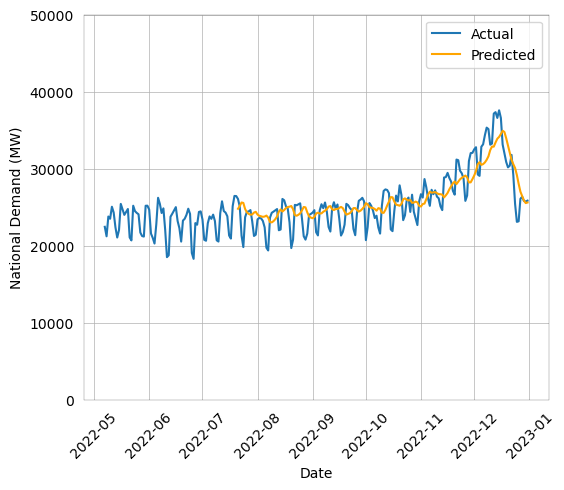

MAPE: 7.239%


In [201]:
plot_fcast_ml(agg_stoc, "2022-05-07", "2022-07-21", "2023-01-01", pred_stoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_stoc, pred_stoc)*100:.3f}%")

### STLF with Exogenous Variables

In [202]:
stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")

In [203]:
scaler_stmc = MinMaxScaler(feature_range=(0, 1))

sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)

In [204]:
stmc_model = Sequential()
stmc_model.add(InputLayer((SEASON_STLF, 4)))
stmc_model.add(LSTM(512, return_sequences=True))
stmc_model.add(LSTM(512))
stmc_model.add(Dense(32, 'relu'))
stmc_model.add(Dense(4, 'linear'))

stmc_model.summary()

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_208 (LSTM)                 │ (None, 6, 512)         │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_209 (LSTM)                 │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,174,564 (12.11 MB)

 Trainable params: 3,174,564 (12.11 MB)

 Non-trainable params: 0 (0.00 B)

In [205]:
cp = ModelCheckpoint('models/stmc_model.keras', save_best_only=True)
stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.1811 - root_mean_squared_error: 0.4237 - val_loss: 0.0826 - val_root_mean_squared_error: 0.2874
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0760 - root_mean_squared_error: 0.2750 - val_loss: 0.0748 - val_root_mean_squared_error: 0.2736
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0527 - root_mean_squared_error: 0.2293 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2593
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0402 - root_mean_squared_error: 0.2004 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2533
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0363 - root_mean_squared_error: 0.1904 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2346
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0536 - val_root_mean_squared_error: 0.2315
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0348 - roo

In [206]:
stmc_model = load_model('models/stmc_model.keras')

pred_stmc = stmc_model.predict(Xts_stmc)
pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]

yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


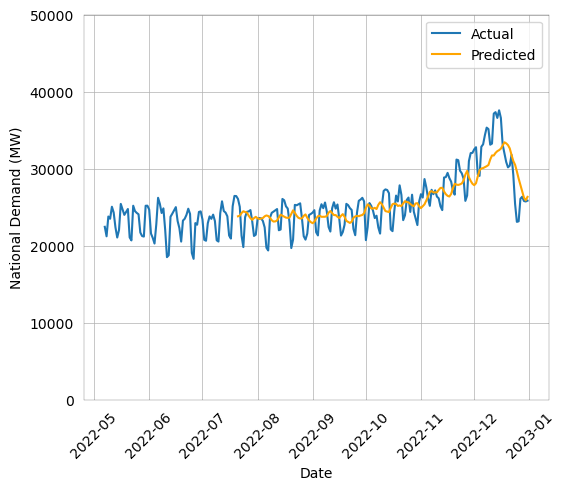

MAPE: 7.499%


In [207]:
plot_fcast_ml(stmc, "2022-05-07", "2022-07-21", "2023-01-01", pred_stmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_stmc, pred_stmc)*100:.3f}%")

## GRU (Gated Recurrent Unit)

### LTLF

In [208]:
scaler_gltoc = MinMaxScaler(feature_range=(0, 1))

In [209]:
agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])

In [210]:
Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)

In [211]:
gltoc_model = Sequential()
gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
gltoc_model.add(GRU(128, return_sequences=True))
gltoc_model.add(GRU(128))
gltoc_model.add(Dense(8, 'relu'))
gltoc_model.add(Dense(1, 'linear'))

In [212]:
cp = ModelCheckpoint('models/gltoc_model.keras', save_best_only=True)
gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [213]:
gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.1716 - root_mean_squared_error: 0.4141 - val_loss: 0.1141 - val_root_mean_squared_error: 0.3378
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0700 - root_mean_squared_error: 0.2644 - val_loss: 0.1338 - val_root_mean_squared_error: 0.3658
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0746 - root_mean_squared_error: 0.2731 - val_loss: 0.1022 - val_root_mean_squared_error: 0.3197
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0522 - root_mean_squared_error: 0.2285 - val_loss: 0.0963 - val_root_mean_squared_error: 0.3103
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0601 - root_mean_squared_error: 0.2448 - val_loss: 0.0920 - val_root_mean_squared_error: 0.3034
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0556 - root_mean_squared_error: 0.2355 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2903
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0477 - roo

In [214]:
gltoc_model = load_model('models/gltoc_model.keras')

pred_gltoc = gltoc_model.predict(Xts_gltoc)
pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)

yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


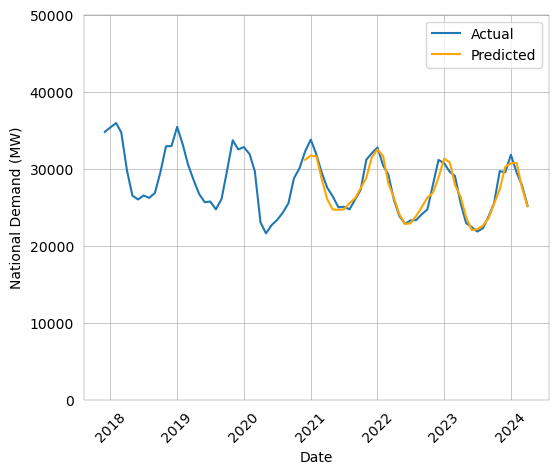

MAPE: 2.910%


In [215]:
plot_fcast_ml(agg_gltoc, "2017-12-01", "2020-12-01", "2024-05-01", pred_gltoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_gltoc, pred_gltoc)*100:.3f}%")

### LTLF with Exogenous Variables

In [216]:
scaler_gltmc = MinMaxScaler(feature_range=(0, 1))

sctr_gltmc = scaler_gltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)

In [217]:
gltmc_model = Sequential()
gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
gltmc_model.add(GRU(512, return_sequences=True))
gltmc_model.add(GRU(256))
gltmc_model.add(Dense(32, 'relu'))
gltmc_model.add(Dense(4, 'linear'))

gltmc_model.summary()

Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_142 (GRU)                   │ (None, 11, 512)        │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_143 (GRU)                   │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,364 (5.32 MB)

 Trainable params: 1,395,364 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [218]:
cp = ModelCheckpoint('models/gltmc_model.keras', save_best_only=True)
gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 0.2305 - root_mean_squared_error: 0.4798 - val_loss: 0.1495 - val_root_mean_squared_error: 0.3866
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0975 - root_mean_squared_error: 0.3120 - val_loss: 0.0906 - val_root_mean_squared_error: 0.3011
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0595 - root_mean_squared_error: 0.2439 - val_loss: 0.0637 - val_root_mean_squared_error: 0.2525
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0457 - root_mean_squared_error: 0.2138 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2502
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0394 - root_mean_squared_error: 0.1981 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0236 - root_mean_squared_error: 0.1533 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2059
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0260 

In [219]:
gltmc_model = load_model('models/gltmc_model.keras')

pred_gltmc = gltmc_model.predict(Xts_gltmc)
pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]

yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


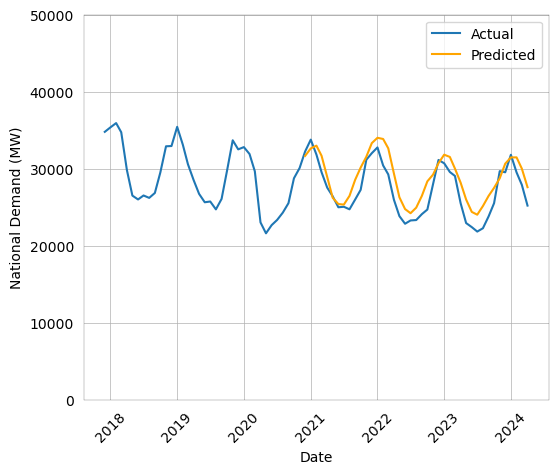

MAPE: 6.755%


In [220]:
plot_fcast_ml(ltmc, "2017-12-01", "2020-12-01", "2024-05-01", pred_gltmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_gltmc, pred_gltmc)*100:.3f}%")

### STLF

In [221]:
scaler_gstoc = MinMaxScaler(feature_range=(0, 1))

sctr_gstoc = scaler_gstoc.fit_transform(agg_stoc[agg_stoc.index < pd.to_datetime("2022-05-01")])
scvl_gstoc = scaler_gstoc.fit_transform(agg_stoc[(agg_stoc.index >= pd.to_datetime("2022-05-01")) & (agg_stoc.index < pd.to_datetime("2022-07-15"))])
scts_gstoc = scaler_gstoc.fit_transform(agg_stoc[agg_stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)

In [222]:
gstoc_model = Sequential()
gstoc_model.add(InputLayer((SEASON_STLF, 1)))
gstoc_model.add(GRU(256, return_sequences=True))
gstoc_model.add(GRU(256))
gstoc_model.add(Dense(8, 'relu'))
gstoc_model.add(Dense(1, 'linear'))

gstoc_model.summary()

Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_144 (GRU)                   │ (None, 6, 256)         │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_145 (GRU)                   │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,729 (2.27 MB)

 Trainable params: 595,729 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [223]:
cp = ModelCheckpoint('models/gstoc_model.keras', save_best_only=True)
gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 1.4777 - root_mean_squared_error: 1.1720 - val_loss: 0.1238 - val_root_mean_squared_error: 0.3519
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1000 - root_mean_squared_error: 0.3155 - val_loss: 0.1922 - val_root_mean_squared_error: 0.4384
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1114 - root_mean_squared_error: 0.3332 - val_loss: 0.1077 - val_root_mean_squared_error: 0.3283
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0651 - root_mean_squared_error: 0.2548 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2339
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0400 - root_mean_squared_error: 0.2000 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2249
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0294 - root_mean_squared_error: 0.1713 - val_loss: 0.0542 - val_root_mean_squared_error: 0.2328
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0311 - roo

In [224]:
gstoc_model = load_model('models/gstoc_model.keras')

pred_gstoc = gstoc_model.predict(Xts_gstoc)
pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)

yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


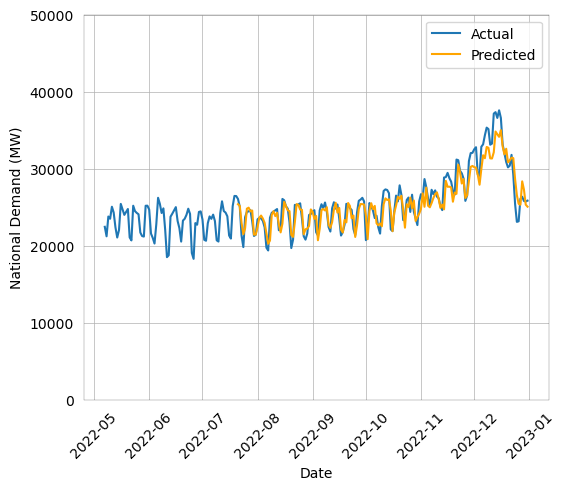

MAPE: 4.408%


In [225]:
plot_fcast_ml(agg_stoc, "2022-05-07", "2022-07-21", "2023-01-01", pred_gstoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_gstoc, pred_gstoc)*100:.3f}%")

### STLF with Exogenous Variables

In [226]:
scaler_gstmc = MinMaxScaler(feature_range=(0, 1))

sctr_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_gstmc = scaler_gstmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)

In [227]:
gstmc_model = Sequential()
gstmc_model.add(InputLayer((SEASON_STLF, 4)))
gstmc_model.add(GRU(512, return_sequences=True))
gstmc_model.add(GRU(512))
gstmc_model.add(Dense(32, 'relu'))
gstmc_model.add(Dense(4, 'linear'))

gstmc_model.summary()

Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_146 (GRU)                   │ (None, 6, 512)         │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_147 (GRU)                   │ (None, 512)            │     1,575,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,132 (9.11 MB)

 Trainable params: 2,388,132 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

In [228]:
cp = ModelCheckpoint('models/gstmc_model.keras', save_best_only=True)
gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp])


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.1674 - root_mean_squared_error: 0.4064 - val_loss: 0.0590 - val_root_mean_squared_error: 0.2429
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0470 - root_mean_squared_error: 0.2167 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2422
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0400 - root_mean_squared_error: 0.2000 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2440
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0323 - root_mean_squared_error: 0.1797 - val_loss: 0.0542 - val_root_mean_squared_error: 0.2327
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.0591 - val_root_mean_squared_error: 0.2430
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0314 - root_mean_squared_error: 0.1771 - val_loss: 0.0591 - val_root_mean_squared_error: 0.2432
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0315 - roo

In [229]:
gstmc_model = load_model('models/gstmc_model.keras')

pred_gstmc = gstmc_model.predict(Xts_gstmc)
pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]

yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


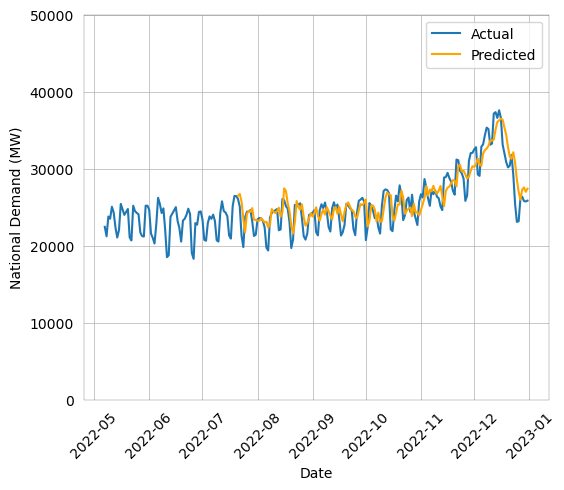

MAPE: 6.026%


In [230]:
plot_fcast_ml(stmc, "2022-05-07", "2022-07-21", "2023-01-01", pred_gstmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_gstmc, pred_gstmc)*100:.3f}%")

## MAPE Averaging

WARNING: do not run unless you are willing to wait for 1.5 - 3hrs (depending on hardware)!

In [231]:
def ltoc_run() -> float:
    scaler_ltoc = MinMaxScaler(feature_range=(0, 1))
    agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
    scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
    scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)
    Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
    Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)
    ltoc_model = Sequential()
    ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    ltoc_model.add(LSTM(128, return_sequences=True))
    ltoc_model.add(LSTM(128))
    ltoc_model.add(Dense(8, 'relu'))
    ltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp], verbose=0)
    ltoc_model = load_model('intermediate.keras')
    pred_ltoc = ltoc_model.predict(Xts_ltoc, verbose=0)
    pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)
    yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)
   
    return mean_absolute_percentage_error(yts_ltoc, pred_ltoc) * 100

In [232]:
def gltoc_run() -> float:
    scaler_gltoc = MinMaxScaler(feature_range=(0, 1))
    agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
    scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
    scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
    Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
    Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)
    gltoc_model = Sequential()
    gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    gltoc_model.add(GRU(128, return_sequences=True))
    gltoc_model.add(GRU(128))
    gltoc_model.add(Dense(8, 'relu'))
    gltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp], verbose=0)
    gltoc_model = load_model('intermediate.keras')
    pred_gltoc = gltoc_model.predict(Xts_gltoc, verbose=0)
    pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)
    yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)
   
    return mean_absolute_percentage_error(yts_gltoc, pred_gltoc) * 100

In [233]:
def stoc_run() -> float:
    agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_stoc = MinMaxScaler(feature_range=(0, 1))
    sctr_stoc = scaler_stoc.fit_transform(agg_stoc[agg_stoc.index < pd.to_datetime("2022-05-01")])
    scvl_stoc = scaler_stoc.fit_transform(agg_stoc[(agg_stoc.index >= pd.to_datetime("2022-05-01")) & (agg_stoc.index < pd.to_datetime("2022-07-15"))])
    scts_stoc = scaler_stoc.fit_transform(agg_stoc[agg_stoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
    Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
    Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)
    stoc_model = Sequential()
    stoc_model.add(InputLayer((SEASON_STLF, 1)))
    stoc_model.add(LSTM(256, return_sequences=True))
    stoc_model.add(LSTM(256))
    stoc_model.add(Dense(8, 'relu'))
    stoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp], verbose=0)
    stoc_model = load_model('intermediate.keras')
    pred_stoc = stoc_model.predict(Xts_stoc, verbose=0)
    pred_stoc = scaler_stoc.inverse_transform(pred_stoc)
    yts_stoc = scaler_stoc.inverse_transform(yts_stoc)
    

    return mean_absolute_percentage_error(yts_stoc, pred_stoc) * 100

In [234]:
def gstoc_run() -> float:
    agg_gstoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_gstoc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index < pd.to_datetime("2022-05-01")])
    scvl_gstoc = scaler_gstoc.fit_transform(agg_gstoc[(agg_gstoc.index >= pd.to_datetime("2022-05-01")) & (agg_gstoc.index < pd.to_datetime("2022-07-15"))])
    scts_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
    Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
    Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)
    gstoc_model = Sequential()
    gstoc_model.add(InputLayer((SEASON_STLF, 1)))
    gstoc_model.add(GRU(256, return_sequences=True))
    gstoc_model.add(GRU(256))
    gstoc_model.add(Dense(8, 'relu'))
    gstoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp], verbose=0)
    gstoc_model = load_model('intermediate.keras')
    pred_gstoc = gstoc_model.predict(Xts_gstoc, verbose=0)
    pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)
    yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)
    
    return mean_absolute_percentage_error(yts_gstoc, pred_gstoc) * 100

In [235]:
def ltmc_run() -> float:
    ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_ltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
    scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
    Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
    Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)
    ltmc_model = Sequential()
    ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    ltmc_model.add(LSTM(512, return_sequences=True))
    ltmc_model.add(LSTM(256))
    ltmc_model.add(Dense(32, 'relu'))
    ltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp], verbose=0)
    ltmc_model = load_model('intermediate.keras')
    pred_ltmc = ltmc_model.predict(Xts_ltmc, verbose=0)
    pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]
    yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

    return mean_absolute_percentage_error(yts_ltmc, pred_ltmc) * 100

In [236]:
def gltmc_run() -> float:
    gltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_gltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gltmc = scaler_gltmc.fit_transform(gltmc[gltmc.index < pd.to_datetime("2017-01-01")])
    scvl_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2017-01-01")) & (gltmc.index < pd.to_datetime("2020-01-01"))])
    scts_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2020-01-01")) & (gltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
    Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
    Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)
    gltmc_model = Sequential()
    gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    gltmc_model.add(LSTM(512, return_sequences=True))
    gltmc_model.add(LSTM(256))
    gltmc_model.add(Dense(32, 'relu'))
    gltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp], verbose=0)
    gltmc_model = load_model('intermediate.keras')
    pred_gltmc = gltmc_model.predict(Xts_gltmc, verbose=0)
    pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]
    yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

    return mean_absolute_percentage_error(yts_gltmc, pred_gltmc) * 100

In [237]:
def stmc_run():
    stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")
    scaler_stmc = MinMaxScaler(feature_range=(0, 1))
    sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
    scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
    Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
    Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)
    stmc_model = Sequential()
    stmc_model.add(InputLayer((SEASON_STLF, 4)))
    stmc_model.add(LSTM(512, return_sequences=True))
    stmc_model.add(LSTM(512))
    stmc_model.add(Dense(32, 'relu'))
    stmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp], verbose=0)
    stmc_model = load_model('intermediate.keras')
    pred_stmc = stmc_model.predict(Xts_stmc, verbose=0)
    pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]
    yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

    return mean_absolute_percentage_error(yts_stmc, pred_stmc) * 100

In [238]:
def gstmc_run():
    gstmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")
    scaler_gstmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index < pd.to_datetime("2022-05-01")])
    scvl_gstmc = scaler_gstmc.fit_transform(gstmc[(gstmc.index >= pd.to_datetime("2022-05-01")) & (gstmc.index < pd.to_datetime("2022-07-15"))])
    scts_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
    Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
    Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)
    gstmc_model = Sequential()
    gstmc_model.add(InputLayer((SEASON_STLF, 4)))
    gstmc_model.add(LSTM(512, return_sequences=True))
    gstmc_model.add(LSTM(512))
    gstmc_model.add(Dense(32, 'relu'))
    gstmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp], verbose=0)
    gstmc_model = load_model('intermediate.keras')
    pred_gstmc = gstmc_model.predict(Xts_gstmc, verbose=0)
    pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]
    yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

    return mean_absolute_percentage_error(yts_gstmc, pred_gstmc) * 100

In [239]:

results = {
    "ltoc":[], "gltoc":[], "stoc":[], "gstoc":[], "ltmc":[], "gltmc":[], "stmc":[], "gstmc":[]
    }

In [259]:
results["ltoc"] = []

In [260]:

for i in range(30):
    results["ltoc"].append(ltoc_run())
    print(i+1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [241]:

for i in range(30):
    results["gltoc"].append(gltoc_run())
    print(i+1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [242]:

for i in range(30):
    results["stoc"].append(stoc_run())
    print(i+1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [244]:

for i in range(30):
    results["gstoc"].append(gstoc_run())
    print(i+1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [245]:

for i in range(30):
    results["ltmc"].append(ltmc_run())
    print(i+1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [246]:

for i in range(30):
    results["gltmc"].append(gltmc_run())
    print(i+1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [247]:

for i in range(30):
    results["stmc"].append(stmc_run())
    print(i+1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [248]:

for i in range(30):
    results["gstmc"].append(gstmc_run())
    print(i+1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [261]:

mean_list = [np.mean(results["ltoc"]), np.mean(results["gltoc"]), np.mean(results["stoc"]), np.mean(results["gstoc"]), 
np.mean(results["ltmc"]), np.mean(results["gltmc"]), np.mean(results["stmc"]), np.mean(results["gstmc"])]

mean_list


[4.122010269053147,
 3.1297615824998517,
 7.432395213690713,
 5.870100220449143,
 7.351555955758726,
 7.20473635956852,
 8.11287074411581,
 8.68850586319902]

In [262]:

std_list = [np.std(results["ltoc"]), np.std(results["gltoc"]), np.std(results["stoc"]), np.std(results["gstoc"]), 
np.std(results["ltmc"]), np.std(results["gltmc"]), np.std(results["stmc"]), np.std(results["gstmc"])]

std_list


[1.999557861568586,
 0.21754730009949955,
 0.2984992942899123,
 1.3138649368238418,
 1.1304990780862527,
 1.3832957700538688,
 0.7459683417552571,
 1.6802336635049684]

In [263]:

def conf_interval(mean: float, std: float) -> (float, float, float):
    return (mean - std * 1.96, mean, mean + std * 1.96)


In [264]:
for m, s in zip(mean_list, std_list):
    print(conf_interval(m, s))


(0.20287686037871877, 4.122010269053147, 8.041143677727575)
(2.7033688743048327, 3.1297615824998517, 3.5561542906948707)
(6.847336596882485, 7.432395213690713, 8.01745383049894)
(3.2949249442744133, 5.870100220449143, 8.445275496623873)
(5.135777762709671, 7.351555955758726, 9.567334148807781)
(4.493476650262938, 7.20473635956852, 9.915996068874103)
(6.650772794275506, 8.11287074411581, 9.574968693956114)
(5.395247882729283, 8.68850586319902, 11.981763843668759)


### Results

Confidence intervals at 95% of MAPE:
```
model   (lower bound,        mean,             upper bound)
-----------------------------------------------------------------
ltoc    (0.202876860378719, 4.122010269053147, 8.041143677727575)
gltoc   (2.703368874304833, 3.129761582499852, 3.556154290694871)
stoc    (6.847336596882485, 7.432395213690713, 8.017453830498940)
gstoc   (3.294924944274413, 5.870100220449143, 8.445275496623873)
ltmc    (5.135777762709671, 7.351555955758726, 9.567334148807781)
gltmc   (4.493476650262938, 7.204736359568520, 9.915996068874103)
stmc    (6.650772794275506, 8.112870744115810, 9.574968693956114)
gstmc   (5.395247882729283, 8.688505863199020, 11.98176384366876)
```